In [14]:
from Input import *
class Solver:
    def __init__(self,which='PWR',steps = 100):
        self.__ICs = Conditions(which=which)
        self.__pin = Geometry(which=which,Conditions=self.__ICs)
        self.__fluid = Properties(Conditions=self.__ICs,Geometry=self.__pin)
        self.z = np.linspace(0,self.__pin.H,steps)
        return
        
    def plot(self,func):
        assert(func in ['Pressure', 'Fluid Temp', 'Equilibrium Quality', 'Clad Surface'])
        z = self.z
        if func == 'Pressure':
            plt.plot(self.Pfunc(z)*1e-6,z)
            plt.ylabel('Axial Location  [m]')
            plt.xlabel('Pressure  [MPa]')
        elif func == 'Fluid Temp':
            plt.plot(self.TfluidFunc(z),z, label = 'Fluid Temperature')
            plt.plot([self.__fluid.tsat(_p*1e-6) for _p in self.Pfunc(z)],z, label = 'T$_{sat}$')
            plt.ylabel('Axial Location  [m]')
            plt.xlabel('Temperature  [K]')
            plt.legend()
        elif func == 'Equilibrium Quality':
            plt.plot(self.Xefunc(z),z)
            plt.ylabel('Axial Location  [m]')
            plt.xlabel('Equilibrium Quality')

        elif func == 'Clad Surface':
            plt.plot(self.T_cs(z),z, label = 'Clad Surface')
            plt.ylabel('Axial Location  [m]')
            plt.xlabel('Temperature  [K]')
            plt.legend()
        plt.grid(visible=True)
        
    def __Momentum(self):
        '''
        Solving P^{i+1} = -dz ( f G^2 xiw / (2 rho Af) + rho g) + Pressure^{i}
        '''
        _ICs,_fluid = self.__ICs, self.__fluid
        z = self.z
        Pressure = [_ICs.P0]
        
        for i in range(len(z)-1):
            dz = z[i+1]- z[i]
            inside = (_fluid.f* _ICs.G**2* _fluid.xiw)/ (2* _fluid.rho* _fluid.Area)+ _fluid.rho* _ICs.g
            Pressure.append(-dz * inside + Pressure[i])
        Pressure = np.array(Pressure)
        def linear_fit(x,A,B):
            return A+ x*B
        self.Pfunc = np.polynomial.Polynomial(scp.optimize.curve_fit(linear_fit,z,Pressure)[0])
        return
    
    def __Energy(self):
        '''
        Solving X_e^{i+1} = dz(1\ hfg [ q'' xih / Af -  (X_e dhfgdp + dhfdp) dpdz]) + X_e^{i}
        '''
        _ICs, _pin, _fluid = self.__ICs, self.__pin, self.__fluid
        z, Pfunc = self.z,self.Pfunc
        
        X_e = [_fluid.X_e0]
        T_f = [_ICs.Tf0]
        for i in range(len(z)-1):
            dz = z[i+1]- z[i]
            zi = z[i]
            mpa = Pfunc(zi)*1e-6
            '''
            Not super sure why inner_chunk*1e4, then by 1e-4 but it works
            I suspect I messed up an area somewhere
            '''
            inner_chunk = (X_e[i] * _fluid.dhfgdp(Pfunc(zi)) + _fluid.dhfdp(Pfunc(zi))) * Pfunc.deriv()(zi)*1e4
            next_X_e = dz * 1/ _fluid.hfg(mpa) * (_pin.qp(zi) / _fluid.Area - inner_chunk)*1e-4 + X_e[i]
            X_e.append(next_X_e)
            T_f.append(_fluid.hfg(mpa) / _fluid.cp * next_X_e + _fluid.tsat(mpa))
    
        self.Xefunc = scp.interpolate.interp1d(z,X_e)
        self.TfluidFunc = scp.interpolate.interp1d(z,T_f)
        return

    def solveFluid(self):
        self.__Momentum()
        self.__Energy()
        return

    def solveClad(self):
        self.T_cs = lambda z: self.__pin.qpp(z) / self.__fluid.h + self.TfluidFunc(z)
        '''second order finite difference...'''
        return

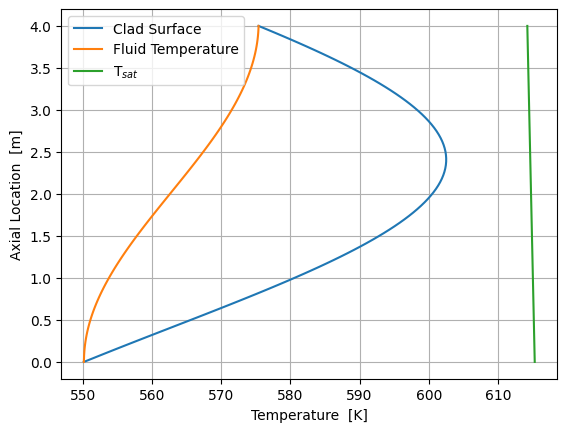

In [15]:
solver = Solver()
solver.solveFluid()
solver.solveClad()
solver.plot('Clad Surface')
solver.plot('Fluid Temp')